In [134]:
%matplotlib inline

In [135]:
"""
This class is responsible for loading the data and run inference on the data with SAM-2
"""
#

# if using Apple MPS, fall back to CPU for unsupported ops

import sys
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

#sys.path.append(os.path.dirname(os.path.abspath(__file__)))
from data.gather_raw_data import ToTensor,get_target_sequence_dataloader

import numpy as np
import torch

import matplotlib.pyplot as plt


from PIL import Image

def init_device(device_name:str='cuda:4'):
    """
    Initialize the compute env,
    """
    # select the device for computation
    if torch.cuda.is_available():
        device = torch.device(device_name)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"using device: {device}")

    if device.type == "cuda":
        # use bfloat16 for the entire notebook
        torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        if torch.cuda.get_device_properties(0).major >= 8:
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
    elif device.type == "mps":
        print(
            "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
            "give numerically different outputs and sometimes degraded performance on MPS. "
            "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
        )
    return device
    
def load_data():
    transform = ToTensor()
    
    # Create dataloader
    train_loader = get_target_sequence_dataloader(
        root_dir="/path/to/your/data",
        target_id="104.0",
        batch_size=32,
        sequence_length=2,
        transform=transform,
        num_workers=4
    )
    return train_loader
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders=True):
    """
    Display a mask overlay on an axis
    Args:
        mask: numpy array or tensor mask
        ax: matplotlib axis
        random_color: whether to use random color for mask
        borders: whether to show mask borders
    """
    # Convert tensor to numpy if needed
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
    
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.plot()
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
        

def example_img_inference(model_predictor=None,image_path='/home/ian/participant=1_session=2/target_id=407.0_name=monitor/block_i=0_id=3.0/FixationIndex=8_FrameNumber=10241.0.png'):
    device = init_device()
    if model_predictor is None:
        model_predictor = init_sam_2(device)
    #image = Image.open(r'/home/ian/participant=1_session=2/target_id=407.0_name=monitor/block_i=0_id=3.0/FixationIndex=8_FrameNumber=10241.0.png')
    image = Image.open(image_path)
    image = np.array(image.convert("RGB"))
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('on')
    plt.title("Original Image", fontsize=18)
    plt.savefig("original_image.png")
    
    image_tensor=torch.from_numpy(image).permute(2, 0, 1).float().to(device)
    model_predictor.set_image(image_tensor)
    X_coord,Y_coord=247,184
    input_point = np.array([[X_coord, Y_coord]])
    
    input_label = np.array([1])
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.show()
    plt.savefig("clicked_image.png")  
    print(model_predictor._features["image_embed"].shape, model_predictor._features["image_embed"][-1].shape)
    
    print(input_point)
    print(input_label)
    
    
    masks, scores, logits = model_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    
    #masks.shape  # (number_of_masks) x H x W
    #take the first mask since its of the highest score
    mask=masks[0]
    score=scores[0]
    
    point_coords=input_point
    borders=False
    input_labels = input_label
    show_mask(mask, plt.gca(), borders=borders)
    plt.title(f"Mask {0}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
    plt.savefig("segmentated_mask(the highest_prob).png")  
        
def init_sam_2(device):
    """init SAM-2 model
    Args:
        device (): the compute device for the model
    Returns:
        the sam model predictor: 
    """
    from sam2.build_sam import build_sam2
    from sam2.sam2_image_predictor import SAM2ImagePredictor
    print(os.getcwd())
    sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

    predictor = SAM2ImagePredictor(sam2_model)
    return predictor

def process_sequence_batch(model_predictor, frames, coords):
    batch_size = frames.shape[0]  # 22
    seq_length = frames.shape[1]  # 2
    results = []

    for seq_idx in range(seq_length):
        current_frames = frames[:,seq_idx]  # [22, 3, 400, 400]
        current_coords = coords[:,seq_idx]  # [22, 2]
        
        # Debug打印
        if seq_idx == 0:
            print(f"\nProcessing sequence {seq_idx}")
            print(f"Current frames shape: {current_frames.shape}")
            print(f"Current coords shape: {current_coords.shape}")
            # 打印第一个batch的坐标值
            print(f"First coordinate: {current_coords[0]}")

        # 转换图片和坐标
        image_list = []
        point_coords_batch = []
        point_labels_batch = []

        for b in range(batch_size):
            # 处理图片
            img = current_frames[b].permute(1,2,0).cpu().numpy().astype(np.uint8)
            image_list.append(img)
            
            # 处理坐标
            coord = current_coords[b].cpu().numpy()
            point_coords_batch.append(np.array([coord]))  # [1,2] shape
            point_labels_batch.append(np.array([1]))
            
            # Debug第一个batch的数据
            if seq_idx == 0 and b == 0:
                print(f"\nFirst batch details:")
                print(f"Image shape: {img.shape}")
                print(f"Image range: {img.min()} to {img.max()}")
                print(f"Coordinate: {coord}")
                print(f"Point coords shape: {point_coords_batch[-1].shape}")
        
        # 设置图片batch
        model_predictor.set_image_batch(image_list)
        
        # 获取预测
        masks, iou_predictions, low_res_masks = model_predictor.predict_batch(
            point_coords_batch=point_coords_batch,
            point_labels_batch=point_labels_batch,
            multimask_output=True
        )
        
        # Debug第一个batch的结果
        if seq_idx == 0:
            print(f"\nFirst batch results:")
            print(f"Number of masks: {len(masks)}")
            print(f"First mask shape: {masks[0].shape}")
            print(f"First score: {iou_predictions[0]}")
        
        frame_results = {
            'masks': masks,
            'scores': iou_predictions,
            'low_res_masks': low_res_masks,
            'coords': point_coords_batch
        }
        results.append(frame_results)
        
    return results




In [136]:
len(dataloader.dataset)


22

Coords shape: torch.Size([22, 2, 2])
All coords:
 tensor([[[179., 224.],
         [177., 227.]],

        [[215., 255.],
         [218., 257.]],

        [[239., 203.],
         [248., 203.]],

        [[181., 228.],
         [186., 226.]],

        [[194., 195.],
         [200., 191.]],

        [[221., 182.],
         [219., 179.]],

        [[145., 244.],
         [146., 244.]],

        [[149., 268.],
         [154., 272.]],

        [[209., 210.],
         [210., 209.]],

        [[206., 166.],
         [206., 167.]],

        [[176., 253.],
         [177., 251.]],

        [[204., 261.],
         [207., 260.]],

        [[218., 199.],
         [223., 199.]],

        [[223., 201.],
         [221., 201.]],

        [[196., 198.],
         [192., 198.]],

        [[239., 200.],
         [237., 202.]],

        [[217., 183.],
         [222., 179.]],

        [[170., 208.],
         [167., 211.]],

        [[219., 154.],
         [217., 160.]],

        [[231., 277.],
         [205.,

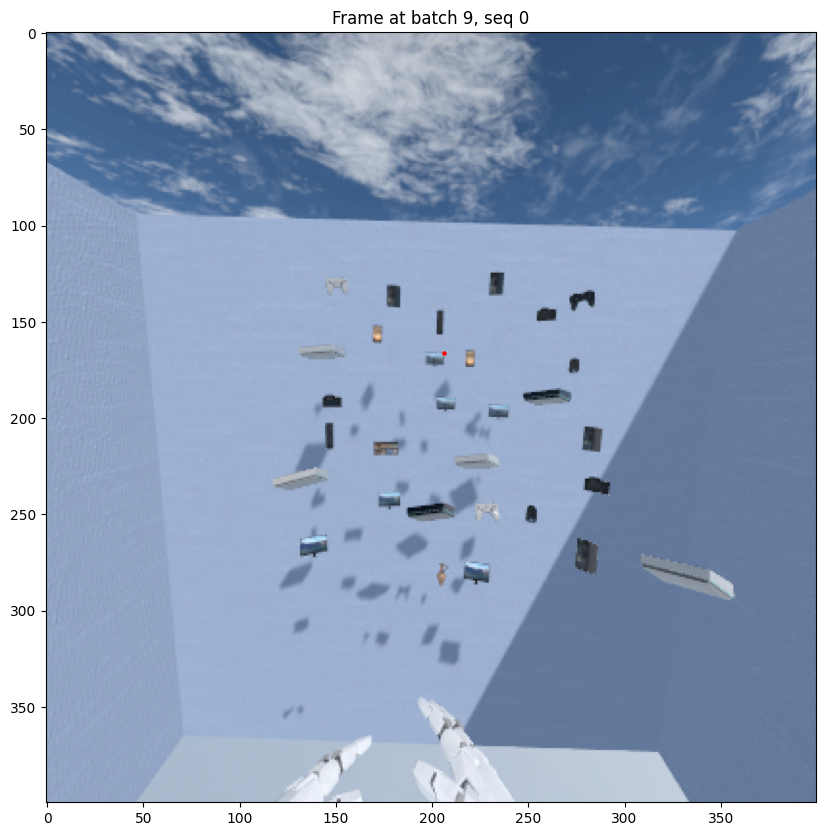

In [137]:
for frames, coords in dataloader:
    print("Coords shape:", coords.shape)
    print("All coords:\n", coords)
    
    # 找到坐标为[206,166]的帧
    for batch_idx in range(coords.shape[0]):
        for seq_idx in range(coords.shape[1]):
            coord = coords[batch_idx,seq_idx]
            if (coord[0] == 206 and (coord[1] == 166 )):
                print(f"\nFound target coordinate at batch {batch_idx}, sequence {seq_idx}")
                print(f"Raw coordinate: {coord}")
                
                # 打印对应的图片信息
                frame = frames[batch_idx,seq_idx]
                print(f"Corresponding frame shape: {frame.shape}")
                print(f"Frame pixel value range: {frame.min().item()} to {frame.max().item()}")
                
                # 可视化
                plt.figure(figsize=(10,10))
                plt.imshow(frame.permute(1,2,0).cpu().numpy().astype(np.uint8))
                plt.scatter(coord[0].item(), coord[1].item(), color='red', marker='o', s=5)
                plt.title(f"Frame at batch {batch_idx}, seq {seq_idx}")
                plt.show()
                
    break

Coords shape: torch.Size([22, 2, 2])
All coords:
 tensor([[[244., 184.],
         [243., 186.]],

        [[223., 201.],
         [221., 201.]],

        [[239., 200.],
         [237., 202.]],

        [[170., 208.],
         [167., 211.]],

        [[145., 244.],
         [146., 244.]],

        [[206., 166.],
         [206., 167.]],

        [[209., 210.],
         [210., 209.]],

        [[181., 228.],
         [186., 226.]],

        [[218., 199.],
         [223., 199.]],

        [[239., 203.],
         [248., 203.]],

        [[179., 224.],
         [177., 227.]],

        [[204., 261.],
         [207., 260.]],

        [[231., 277.],
         [205., 222.]],

        [[176., 253.],
         [177., 251.]],

        [[221., 182.],
         [219., 179.]],

        [[185., 184.],
         [193., 187.]],

        [[149., 268.],
         [154., 272.]],

        [[196., 198.],
         [192., 198.]],

        [[194., 195.],
         [200., 191.]],

        [[217., 183.],
         [222.,

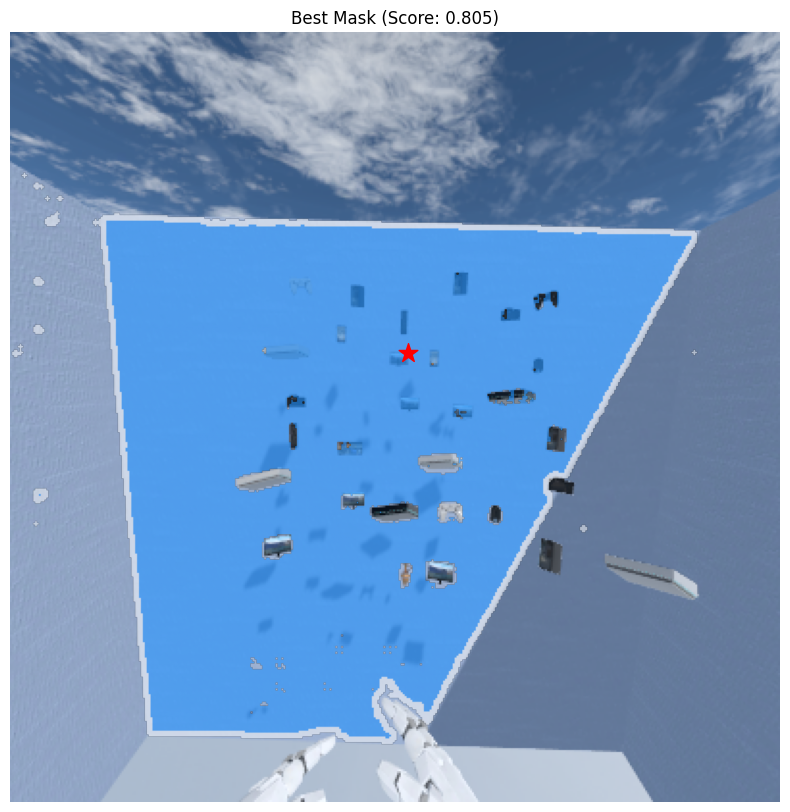

In [138]:
for frames, coords in dataloader:
    print("Coords shape:", coords.shape)
    print("All coords:\n", coords)
    
    # 找到坐标为[206,166]的帧
    for batch_idx in range(coords.shape[0]):
        for seq_idx in range(coords.shape[1]):
            coord = coords[batch_idx,seq_idx]
            if (coord[0] == 206 and (coord[1] == 166)):
                print(f"\nFound target coordinate at batch {batch_idx}, sequence {seq_idx}")
                print(f"Raw coordinate: {coord}")
                
                # 获取对应的图片和坐标
                frame = frames[batch_idx,seq_idx]
                frame_np = frame.permute(1,2,0).cpu().numpy().astype(np.uint8)
                
                # SAM2推理
                model_predictor.set_image(frame_np)
                
                # 准备输入点
                
                input_label = np.array([1])
                
                # 获取预测
                masks, scores, logits = model_predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    multimask_output=True,
                )
                
                # 获取最高分mask
                best_mask_idx = np.argmax(scores)
                best_mask = masks[best_mask_idx]
                best_score = scores[best_mask_idx]
                
                # 可视化
                plt.figure(figsize=(10,10))
                plt.imshow(frame_np)
                show_mask(best_mask, plt.gca(), borders=True)
                plt.scatter(coord[0].item(), coord[1].item(), color='red', marker='*', s=200)
                plt.title(f"Best Mask (Score: {best_score:.3f})")
                plt.axis('off')
                plt.show()
                
                break
    break

In [139]:
for frames, coords in dataloader:
    print("Frames shape:", frames.shape)  # 应该是[22(batch_size), 2(seq_len), 3(RGB), 400, 400]
    print("Coords shape:", coords.shape)  # 应该是[22(batch_size), 2(seq_len), 2(x,y)]
    
    # 检查每个维度的数值
    print("\nFrames dimensions:")
    print(f"Batch size: {frames.shape[0]}")  # 应该是22
    print(f"Sequence length: {frames.shape[1]}")  # 应该是2
    print(f"Channels: {frames.shape[2]}")  # 应该是3
    
    # 检查第一个batch的第一个frame
    current_frames = frames[:,0]  # 取第一帧的所有batch
    print("\nSingle sequence frame shape:", current_frames.shape)  # 应该是[22, 3, 400, 400]
    
    # 打印原始数据信息
    print("Original data:")
    print("Frames shape:", frames.shape)
    print("Coords shape:", coords.shape)
    print("First coordinate:", coords[0,0])
    
    # 处理和对比结果
    frame = frames[0,0]
    coord = coords[0,0]
    
    # 单图处理
    frame_np = frame.permute(1,2,0).cpu().numpy().astype(np.uint8)
    model_predictor.set_image(frame_np)
    masks_single, scores_single, _ = model_predictor.predict(
        point_coords=np.array([[coord[0].item(), coord[1].item()]]),
        point_labels=np.array([1]),
        multimask_output=True
    )
    
    # Batch处理
    batch_results = process_sequence_batch(
        model_predictor, 
        frames[0:1].unsqueeze(1),
        coords[0:1].unsqueeze(1)
    )
    
    # 打印结果对比
    print("\nResults comparison:")
    print("Single image score:", np.max(scores_single))
    print("Batch processing score:", np.max(batch_results[0]['scores'][0]))
    
    break

Frames shape: torch.Size([22, 2, 3, 400, 400])
Coords shape: torch.Size([22, 2, 2])

Frames dimensions:
Batch size: 22
Sequence length: 2
Channels: 3

Single sequence frame shape: torch.Size([22, 3, 400, 400])
Original data:
Frames shape: torch.Size([22, 2, 3, 400, 400])
Coords shape: torch.Size([22, 2, 2])
First coordinate: tensor([149., 268.])

Processing sequence 0
Current frames shape: torch.Size([1, 2, 3, 400, 400])
Current coords shape: torch.Size([1, 2, 2])
First coordinate: tensor([[149., 268.],
        [154., 272.]])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [ ]:
from PIL import Image
img=Image.open("/home/ian/participant=1_session=2/target_id=407.0_name=monitor/block_i=0_id=3.0/FixationIndex=10_FrameNumber=10257.0.png")

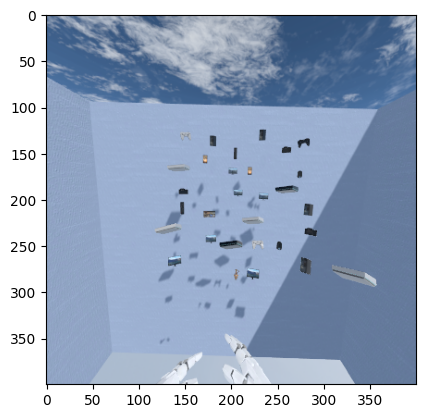

In [ ]:

plt.imshow(img)

In [ ]:
def process_sequence_batch(model_predictor, frames, coords):
    batch_size = frames.shape[0]  # 22
    seq_length = frames.shape[1]  # 2
    results = []

    for seq_idx in range(seq_length):
        current_frames = frames[:,seq_idx]  # [22, 3, 400, 400]
        current_coords = coords[:,seq_idx]  # [22, 2]
        
        # Debug打印
        if seq_idx == 0:
            print(f"\nProcessing sequence {seq_idx}")
            print(f"Current frames shape: {current_frames.shape}")
            print(f"Current coords shape: {current_coords.shape}")
            # 打印第一个batch的坐标值
            print(f"First coordinate: {current_coords[0]}")

        # 转换图片和坐标
        image_list = []
        point_coords_batch = []
        point_labels_batch = []

        for b in range(batch_size):
            # 处理图片
            img = current_frames[b].permute(1,2,0).cpu().numpy().astype(np.uint8)
            image_list.append(img)
            
            # 处理坐标
            coord = current_coords[b].cpu().numpy()
            point_coords_batch.append(np.array([coord]))  # [1,2] shape
            point_labels_batch.append(np.array([1]))
            
            # Debug第一个batch的数据
            if seq_idx == 0 and b == 0:
                print(f"\nFirst batch details:")
                print(f"Image shape: {img.shape}")
                print(f"Image range: {img.min()} to {img.max()}")
                print(f"Coordinate: {coord}")
                print(f"Point coords shape: {point_coords_batch[-1].shape}")
        
        # 设置图片batch
        model_predictor.set_image_batch(image_list)
        
        # 获取预测
        masks, iou_predictions, low_res_masks = model_predictor.predict_batch(
            point_coords_batch=point_coords_batch,
            point_labels_batch=point_labels_batch,
            multimask_output=True
        )
        
        # Debug第一个batch的结果
        if seq_idx == 0:
            print(f"\nFirst batch results:")
            print(f"Number of masks: {len(masks)}")
            print(f"First mask shape: {masks[0].shape}")
            print(f"First score: {iou_predictions[0]}")
        
        frame_results = {
            'masks': masks,
            'scores': iou_predictions,
            'low_res_masks': low_res_masks,
            'coords': point_coords_batch
        }
        results.append(frame_results)
        
    return results

# 测试代码
for frames, coords in dataloader:
    print("Original data shapes:")
    print(f"Frames: {frames.shape}")
    print(f"Coords: {coords.shape}")
    
    # 处理batch
    results = process_sequence_batch(model_predictor, frames, coords)
    
    # 单独处理第一个图像作为对比    break
    single_frame = frames[0,0]  # 第一个batch的第一帧
    single_coord = coords[0,0]  # 对应的坐标
    
    # 单图处理
    frame_np = single_frame.permute(1,2,0).cpu().numpy().astype(np.uint8)
    model_predictor.set_image(frame_np)
    
    masks_single, scores_single, _ = model_predictor.predict(
        point_coords=np.array([single_coord.cpu().numpy()]),
        point_labels=np.array([1]),
        multimask_output=True
    )
    
    print(f"\nComparison of first image:")
    print(f"Single processing score: {np.max(scores_single)}")
    print(f"Batch processing score: {np.max(results[0]['scores'][0])}")
    

Original data shapes:
Frames: torch.Size([22, 2, 3, 400, 400])
Coords: torch.Size([22, 2, 2])

Processing sequence 0
Current frames shape: torch.Size([22, 3, 400, 400])
Current coords shape: torch.Size([22, 2])
First coordinate: tensor([223., 201.])

First batch details:
Image shape: (400, 400, 3)
Image range: 5 to 255
Coordinate: [223. 201.]
Point coords shape: (1, 2)

First batch results:
Number of masks: 22
First mask shape: (3, 400, 400)
First score: [0.9375     0.00093842 0.5703125 ]

Comparison of first image:
Single processing score: 0.9375
Batch processing score: 0.9375


: 